# 5. Programming Behavior

This notebook will go over the basics of how we can programatically simulate new behaviors in `pyevo`.

Thus far, we have been analyzing non-interactive blobs. This works for basic simulations, but for most analyses, blobs will likely be interacting with others and/or the environment.

In order to do this programmatically, we have to:
1. Define a new kind of blob that has a behaviorally interactive mechanism
2. Create a new environment that will enable this new kind of interaction

We'll go over this together as we setup a simulation to study how the evolution of smell impacts population growth

## 5.1 Defining blobs with interactive mechanisms

In order to study the evolution of smell, we first have to define what smell is. It won't do us much food to program all the way down to the olfactory system, so we'll want a high level behavioral replica. For these purposes, we can create a simple model of smell where, if there's food in an environment, blobs that have evolved the sense of smell will move towards that food.

With that definition, we can now start programatically implementing this behavior in a new blob type. Let's first look at what each blob type needs

In [1]:
import sys
sys.path.append('..')
from environment import *
from blobs import *

%load_ext autoreload
%autoreload 2

In [2]:
b = BaseBlob()
blob_methods = [func for func in dir(b) if callable(getattr(b, func)) and not func.startswith("__")]
print(blob_methods)

['move', 'mutation_class', 'repr_class', 'reproduce', 'set_probs']


Here are the methods associated with the `BaseBlob` class. `mutation_class`, `repr_class`, and `set_probs` were covered earlier on in Notebook 2 so we won't pay these too much attention for now. Omitting those, we can see that blobs really only have two main methods: `move`, and `reproduce`. <b>These will be the two primary methods that we override to implement more complex behavior</b>. Let's inspect these methods

In [3]:
b.move??

Signature: b.move(coords: tuple) -> None
Source:   
    def move(self, coords: tuple) -> None:
        """
        Function for determining blob movement. BaseBlob move randomly

        Args:
            coords (tuple): coordinates to move towards. For BaseBlob, this
            is mute since the blobs don't actually move towards the coord
        """
        # Move in random direction (-1 or +1) in increments of step
        self.x += self.step * [-1, 1][random.randrange(2)]
        self.y += self.step * [-1, 1][random.randrange(2)]
File:      ~/virtualenvironment/pyevo/blobs.py
Type:      method


The `move` method seems pretty simple - it returns nothing and just updates the blob's `x` and `y` parameters randomly to reflect random movement. In general the `move` method simple requires a way of updating the `x` and `y` parameters. Thinking ahead to the case of our new blob with smell, we need a way of getting our blob to move towards a coordinate

In [4]:
b.reproduce??

Signature: b.reproduce()
Source:   
    def reproduce(self):
        """
        Generic reproduction function. If mutate, return a generic
        MutatedBaseBlob with attributes defined

        Returns:
            (Blob): the type of Blob produced will depend on the mutation_class
            and repr_class attributes declared in __init__
        """
        mutation_event = random.random()
        if mutation_event <= self.mutation_prob:
            return self.mutation_class()
        else:
            return self.repr_class()
File:      ~/virtualenvironment/pyevo/blobs.py
Type:      method


`reproduce` is similarly simple - it returns another instance of a blob where the blob type is either that of the predefined mutated class (`mutation_class`) or identical to the blob itself (`repr_class`). The way the blob determines which path to go down is by randomly choosing a float and comparing it against the `mutation_prob` attribute. As such, all the `reproduce` method needs is a way of evaluating whether the blob will mutate or not.

Of the two methods, `move` is more relevant to the blob we're defining here as the smell attribute will be reflected in how it moves. We've already defined this class - `BlobWithFoodSense`, so let's see how we updated the `move` function

In [5]:
f = BlobWithFoodSense()
f.move??

Signature: f.move(coords: tuple) -> None
Source:   
    def move(self, coords: tuple) -> None:
        """
        Function for determining blob movement. Moves towards coords in
        units of step

        Args:
            coords (tuple): coordinates to move towards
        """
        self.x += self.step * (1 if self.x < coords[0] else -1)
        self.y += self.step * (1 if self.y < coords[1] else -1)
File:      ~/virtualenvironment/pyevo/blobs.py
Type:      method


As you can see, the change was pretty subtle. All we did was update the function call to accept a tuple corresponding to the coordinate of the food, and then our `BlobWithFoodSense` moves towards this coordinate in increments of `step`. With that, we have effectively created a blob that smells!

But wait now. What even is food? And what will our new blob do once it reaches food? This, and more, are things that will be handled by our new environment

## 5.2 Defining an interactive environment

Similar to above, let's take a look @ our `BaseEnvironment`

In [6]:
e = BaseEnvironment()
e_methods = [func for func in dir(e) if callable(getattr(e, func)) and not func.startswith("__")]
print(e_methods)

['interact', 'plot_growth', 'show_all_generations', 'show_one_generation', 'spawn_population']


`spawn_population` is one we've been using in all notebooks to add a population of blobs into the environment. `plot_growth` and `show_*` have been similarly covered as plotting methods. Thus, the real meat and potatoes of the `pyevo` `BaseEnvironment` class is the `interact` method

In [7]:
e.interact??

Signature: e.interact() -> None
Source:   
    def interact(self) -> None:
        """
        Enables most recent population to interact with environmental
        parameters.
        """
        # Get relevant attrs. For this Environment, survival, reproduction,
        # and mutation
        surv_attrs = get_generation_attributes(
            self.population[-1], "survival_prob"
        )
        repr_attrs = get_generation_attributes(
            self.population[-1], "reproduction_prob"
        )

        # Kill off some portion of population based off Blob survival attrs
        surv_pop, surv_mask = apply_mask_to_population(
            self.population[-1], surv_attrs
        )

        # Surviving population reproduced based off Blob reproduction attrs
        repr_attrs = repr_attrs[surv_mask]
        repr_pop, _ = apply_mask_to_population(surv_pop, repr_attrs)

        # Each blob will reproduce, with a chance of mutation
        new_blobs = []
        for b in repr_pop:
     

Similar to `BaseBlob`'s `move` and `reproduce` functions, the `BaseEnvironment`'s `interact` method is also very simple. The way to think about this method is that a population of blobs goes into the environment, they interact via. this method, and then the surviving generation is appended to the `population` attribute. All that the method has to do if evaluate which blobs survive and which do not.

In this case, the survival (and reproduction/mutation) are determined by a roll of the dice - a random number array is used as a mask over the population's various `(s, m, r)` values to determine, by random chance, which blobs survive or not. Since our new environment does not depend on luck, but rather to the access of food, all we have to do is reflect this in the new `interact` method

In [8]:
g = EnvironmentWithFood(food=10)
g.interact??

Signature: g.interact()
Source:   
    def interact(self):
        """
        Spawns food, then blobs move towards food. Those who eat food
        survive, those who don't roll the dice for survival
        """
        self.spawn_food()

        # Determine what blobs survive based off ability to reach food
        survived = []
        for b in self.population[-1]:
            closest_food, dist = find_closest_food(b, self.food_coords[-1])
            b.move(closest_food)
            new_dist = calculate_distance_to_food(b, closest_food)
            if new_dist < b.size:
                # If within the reach of blob, blob "eats" food and survives
                survived.append(b)
            else:
                # If blob didn't eat, random chance of survival
                rand_surv_prob = random.random()
                if rand_surv_prob < b.survival_prob:
                    survived.append(b)

        # Surviving population rolls dice to reproduce
        repr_attrs = get_gen

Two things worth pointing out here:
1. When we __init__ this new environment, we had to include a `food` parameter. The docstrings indicate that this is to define the number of pieces of food spawned at the beginning of each `interact` cycle. As you can see, each type of environment can have its own characteristics and unique attributes.
2. The new `interact` function really isn't that much more complicated. All it does is spawn food, then calculates the distance between each blob and the closest piece of food and moves them towards the food one step. If a blob is within a certain range of food, it's guaranteed to survive, and if not, it rolls the dice just like in the `BaseEnvironment`'s `interact` function. 

This really is all it takes. To recap, to implement smell, all we had to do was:
1. Update the `move` parameter to move towards a given food coordinate
2. Update the environment's `interact` method to spawn food and execute the actual `move` function

Let's double check that this works. We would expect that in a population of blobs with and without this sense of smell, the blobs with the sense of smell fare off better. For simplicity's sake, we're going to rewrite the class function a bit to remove the possibility of mutation

In [9]:
class NonsmellingBlob(BaseBlob):
    """What is a 'smell'?"""
    def __init__(self) -> None:
        super().__init__()
        self.name = 'NonsmellingBlob'
        self.mutation_class = NonsmellingBlob
        self.repr_class = NonsmellingBlob
        

class SmellingBlob(BlobWithFoodSense):
    """I'm always moving towards food"""
    def __init__(self) -> None:
        super().__init__()
        self.name = 'SmellingBlob'
        self.mutation_class = SmellingBlob
        self.repr_class = SmellingBlob        

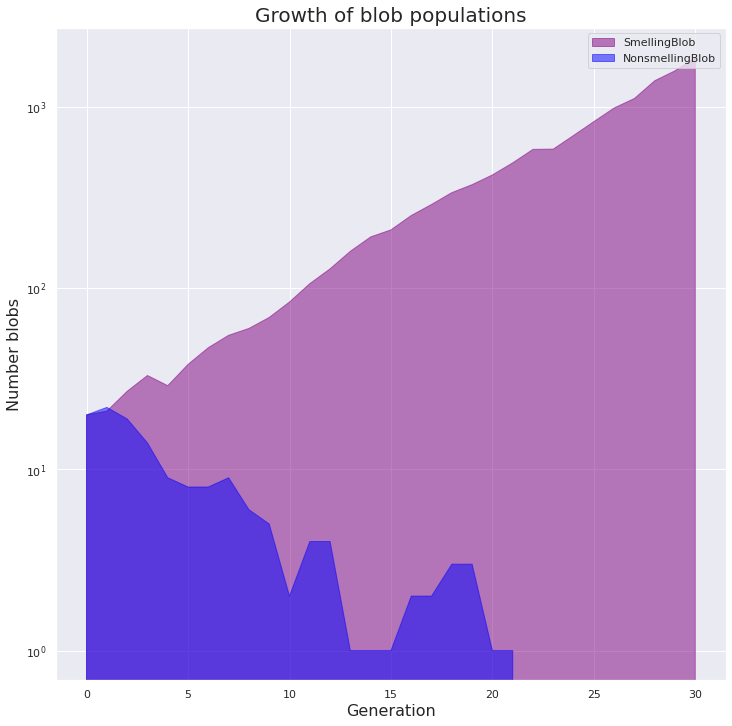

In [10]:
pop = [NonsmellingBlob() for x in range(20)] + [SmellingBlob() for y in range(20)]
g.spawn_population(pop)

for i in range(30):
    g.interact()

g.plot_growth()

As predicted, the `SmellingBlob`s fared significantly better than it's smell-less counterpart. We can even visualize this behavior via the `show_all_generations` method

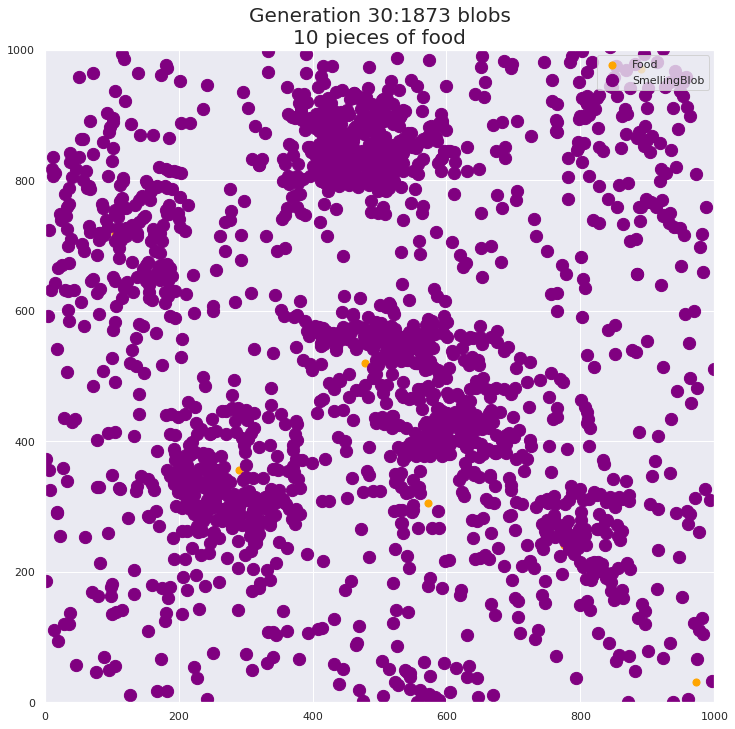

In [11]:
g.show_all_generations()

The `SmellingBlob`s tend to cluster towards where the food is whereas the `NonsmellingBlob`s just wander around aimlessly. One need not be an evolutionary biologist to understand the reproductive benefits this has!

This is really the tip of the iceberg for simulating more complex behaviors in `pyevo`. In effect, anything that confers a survival, reproductive, and/or behavioral advantage or disadvantage can be programatically defined in some combination of these methods. The sky's the limit!